In [21]:
# Package Imports
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt

from shapely.geometry import MultiLineString, LineString, Polygon, Point
from shapely import wkt
from shapely.affinity import rotate, scale

import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show

import pulp

from spopt.locate.coverage import LSCP
from spopt.locate import PMedian

from importlib import reload

# to load the interactive plotting version
#matplotlib widget
# or regular
%matplotlib inline

# Importing my modules
import data_loading, set_cover, plotting, geometry_operations, optimization_functions

##### Reading the data and generate map

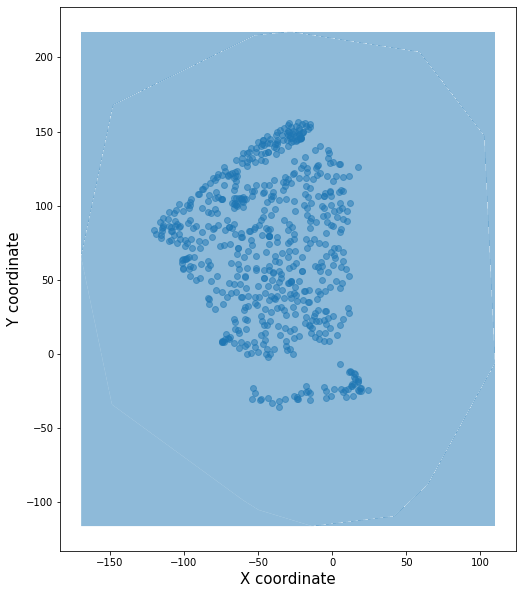

In [22]:
# read TIF and CSV data
forest_area_gdf, bestand_3_csv = data_loading.load_bestand_and_forest()

# add trees to the map
point_list = [Point(xy) for xy in zip(bestand_3_csv["x"], bestand_3_csv["y"])]
tree_gdf = gpd.GeoDataFrame(data=bestand_3_csv,geometry=point_list)

#verify that the boundary and trees add up
plotting.plot_gdfs([tree_gdf, forest_area_gdf])

#### Joining and Overlaying Anchor Areas and Road on the Map

##### Recording coordinates with interactive figure

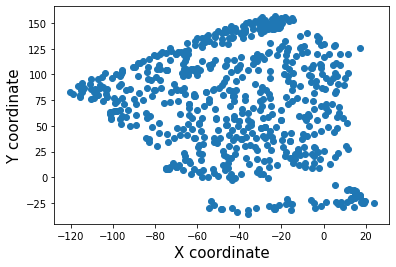

In [23]:
coords = []
fig, ax = plt.subplots()
ax.set_xlabel('X coordinate', fontsize=15)
ax.set_ylabel('Y coordinate', fontsize=15)
ax.scatter(tree_gdf["x"],tree_gdf["y"])

cid = fig.canvas.mpl_connect('button_press_event',  lambda event: plotting.onclick(event,coords))

In [24]:
# disconnect the interactive figure so it doesnt eat up resources
fig.canvas.mpl_disconnect(cid)

##### Creating extra_geometry_gpd from manual coordinates

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


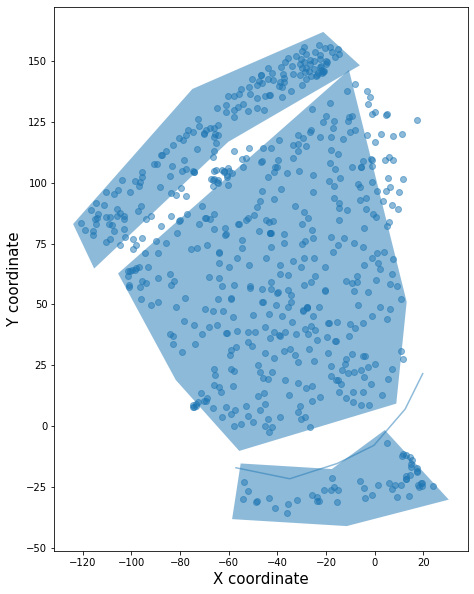

In [25]:
# manually insert those coordinates
# recorded coordinates for the given areas
downhill_anchors = Polygon([Point(xy) for xy in [(-123.88268627035482, 83.05479790035122), (-74.89307684787903, 138.5299549848453), (-21.10056454084676, 161.97821725767267), (-6.051468835903222, 148.2524051955298), (-60.16417466857257, 116.79741921978575), (-115.23746107815322, 64.75371515082742)]])
uphill_anchors = Polygon([Point(xy) for xy in [(-55.04107825837903, -15.31352187833928), (-17.578435758838708, -17.601157222029755), (4.194723984483858, -1.5877098161964227), (30.450593086725803, -30.18315161232738), (-11.49475877173387, -41.04941949485714), (-58.5632070403871, -38.189875315244045)]])
road = LineString([(-57.282432937838706, -17.029248386107135), (-34.86888614324194, -21.604519073488092), (-15.337081079379033, -15.31352187833928), (-0.2879853744354932, -7.878707011345227), (12.51975565104837, 6.990922722642864), (19.884206740701615, 21.86055245663097)])
inner_forest = Polygon([Point(xy) for xy in [(-105.43005197808363, 62.73802056488026), (-10.557896233758669, 146.34023494632802), (13.160142702322588, 51.07259530235265), (8.890895693827957, 9.27148811162877), (-55.62217021231302, -10.17088732591722), (-81.71201304200238, 18.992675830401765)]])

extra_geometry_gpd = gpd.GeoDataFrame(pd.DataFrame({"name":["uphill_anchors","road","downhill_anchors","inner_forest"],"geometry":[uphill_anchors,road,downhill_anchors,inner_forest]}))

# set the name as index to easily select the geometry
extra_geometry_gpd.set_index("name", inplace = True)
extra_geometry_gpd.loc['road']

plotting.plot_gdfs([tree_gdf,extra_geometry_gpd])

#### Generating Eligible Trees and Road Pathway

Getting the points along the road

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/geometry_operations.py:66: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  # skip if we dont have enough candidates


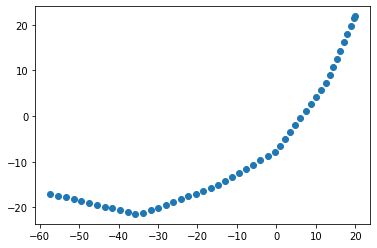

In [26]:
interval = 2
road_points = geometry_operations.generate_road_points(extra_geometry_gpd.loc['road'].geometry, interval)
plotting.plot_scatter_xy(road_points)

Getting the trees contained in the anchor/target tree polygons

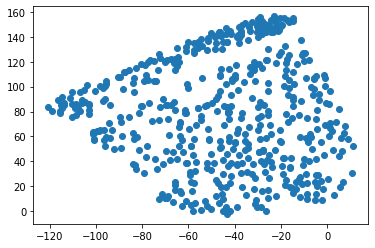

In [27]:
# get the eligible anchor and target trees inside the polygon
anchor_trees_gdf = geometry_operations.filter_gdf_by_contained_elements(tree_gdf, extra_geometry_gpd.loc["uphill_anchors"].geometry)
target_trees_gdf = geometry_operations.filter_gdf_by_contained_elements(tree_gdf,extra_geometry_gpd.loc["downhill_anchors"].geometry)
inner_forest_gdf = geometry_operations.filter_gdf_by_contained_elements(tree_gdf, extra_geometry_gpd.loc["inner_forest"].geometry)
harvesteable_trees_gdf = pd.concat([target_trees_gdf,inner_forest_gdf])

# and check if the anchor trees look good
plotting.plot_scatter_xy(harvesteable_trees_gdf.geometry)

#### Generating Possible Lines

##### Setting and rotating the slope line

59.99999999999999


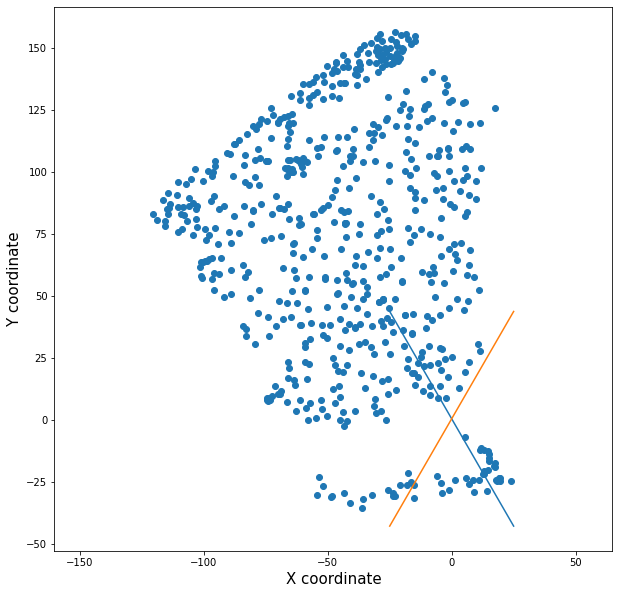

In [28]:
import geometry_utilities
slope_degree = 30

# set a orientation line we can plan the line deviation around
slope_line = LineString([(0,0),(0,1)])
slope_line = rotate(slope_line, slope_degree)

# scale the line by a factor of 100 and plot it
slope_line = scale(slope_line,100,100)

slope_20_deg = rotate(slope_line, 300)
print(geometry_utilities.angle_between(slope_20_deg,slope_line))

ax = plotting.plot_equal_axis(slope_line)
ax.plot(*slope_20_deg.xy)
ax.scatter(bestand_3_csv["x"], bestand_3_csv["y"])

##### Constraining lines to those with suitable anchor trees

<AxesSubplot:>

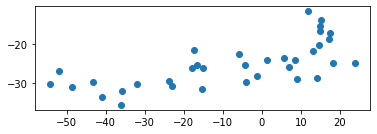

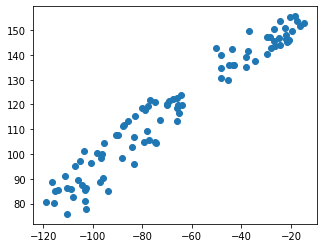

In [40]:
# Filter out uphill anchor trees with min_anchor_diameter < 40
min_anchor_diameter = 30
anchor_trees_gdf_filtered_diameter = anchor_trees_gdf[anchor_trees_gdf["BHD"]>str(min_anchor_diameter)]
anchor_trees_gdf_filtered_diameter.plot()

# And filter the target trees
target_trees_gdf_filtered_diameter = target_trees_gdf[target_trees_gdf["BHD"]>str(min_anchor_diameter)]
target_trees_gdf_filtered_diameter.plot()

##### Generating the possible lines depending on the slope

we have n lines:  754


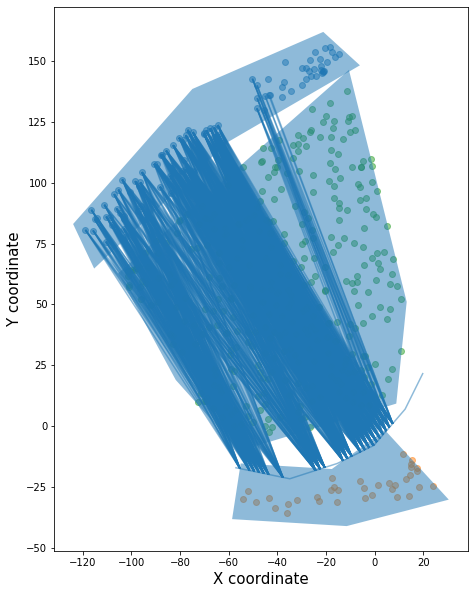

In [41]:
import warnings
import geometry_utilities
reload(geometry_operations)
reload(geometry_utilities)

max_main_line_slope_deviation = 8
max_anchor_distance = 30
possible_lines, slope_deviation, possible_anchor_triples = geometry_operations.generate_possible_lines(road_points, target_trees_gdf_filtered_diameter, anchor_trees_gdf_filtered_diameter, slope_line, max_main_line_slope_deviation, max_anchor_distance)
print("we have n lines: ",len(possible_lines))

line_gdf = gpd.GeoDataFrame(geometry=possible_lines)
#add the length of each line
line_gdf["line_length"] = line_gdf.geometry.length
line_gdf["slope_deviation"] = slope_deviation
line_gdf["possible_anchor_triples"] = possible_anchor_triples

plotting.plot_gdfs([target_trees_gdf_filtered_diameter,anchor_trees_gdf_filtered_diameter, inner_forest_gdf, extra_geometry_gpd,line_gdf])

<AxesSubplot:>

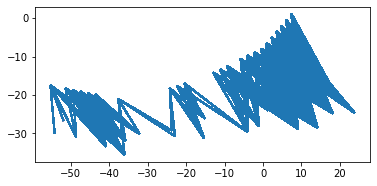

In [42]:
# very ugly list decomprehension
sublist = [item for sublist in line_gdf["possible_anchor_triples"] for item in sublist]
b = [item for subliste in sublist for item in subliste]
c = gpd.GeoSeries(b)
c.plot()

#### Optimization Setup

In [43]:
# Apply the Line Cost Function:
line_gdf["line_cost"] = optimization_functions.line_cost_function(line_gdf["line_length"],line_gdf["slope_deviation"])

# Create a matrix with the distance between every tree and line
cost_matrix = geometry_operations.compute_distances_facilities_clients(harvesteable_trees_gdf, line_gdf)

# sort the facility (=lines) and demand points (=trees)
facility_points_gdf = line_gdf.reset_index()
demand_points_gdf = harvesteable_trees_gdf.reset_index()

#### SpOPT

Creating our custom problem with constraints

- Obj Func v4:
	- ```sum(lscp.aij[cli][fac] * cli_assgn_vars[cli][fac])```
		- minimize the overall distance between clients and the factory they are assigned too
	- ```sum(fac_vars[fac]*fac_cost[fac] for fac in facility_range])```
		- minimize the sum of factory costs

- Matrices:
	- Lineactiveindex = fac_vars = $[l1+l2...]$
	- linetreeactiveindex = cli_assgn_vars = $[[l1*cli1+l1*cli2...],[l2*cli1+l2*cli2+....]]$

	- fac_cost: the cost of each line
	- cli_demand: mocked variable as of now, can be changed to reflect profit of given tree

- Constraints:
	- Constraint 1:
		- Each client is only assigned to one factory: ```pulp.lpSum([cli_assgn_vars[cli][fac] for fac in facility_range]) == 1```

	- Constraint 2: 
		- Every factory that has a client assigned must be opened: ```lscp.problem += fac_vars[fac] - cli_assgn_vars[cli][fac] >= 0```



In [44]:
solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)
name = "model"

# create the nr of possible facilities and clients 
client_range = range(cost_matrix.shape[0])
facility_range = range(cost_matrix.shape[1])

# and a mocked up facility cost
facility_cost = [2000 for fac in facility_range]
client_demand = [50 for cli in client_range]

# create the aij cost matrix
weights = np.reshape(client_demand, (cost_matrix.shape[0], 1))
aij = weights * cost_matrix

# init the model with name and the problem - this only gives it a name and tells it to minimize the obj function
problem = pulp.LpProblem(name, pulp.LpMinimize)
model = PMedian(name, problem, aij)

# Add the facilities as fac_vars and facility_clients as cli_assgn_vars
optimization_functions.add_facility_variables(model, facility_range)
optimization_functions.add_facility_client_variables(model, facility_range, client_range)

# Add the objective functions
optimization_functions.add_moo_objective_function(model, facility_range, client_range, facility_cost)

# Assignment/demand constraint - each client should only be assigned to one factory
optimization_functions.add_singular_assignment_constraint(model, facility_range, client_range)

# Add opening/shipping constraint - each factory that has a client assigned to it should also be opened
optimization_functions.add_facility_is_opened_constraint(model, facility_range, client_range)

model = model.solve(solver)

KeyboardInterrupt: 

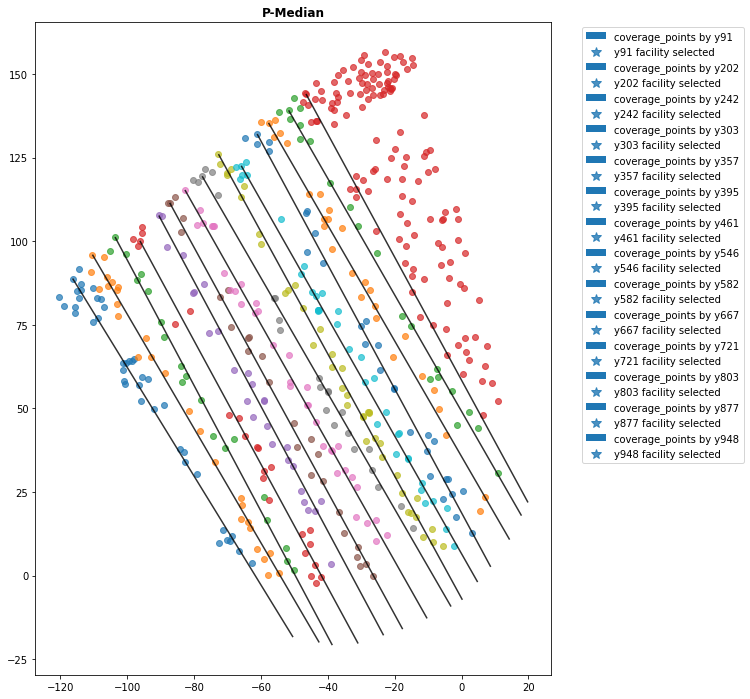

In [ ]:
reload(plotting)
plotting.plot_p_median_results(model, facility_points_gdf, demand_points_gdf)